## NOTE

### What I did
* Added Batch normalization
* Put .2 in LaekyRelu layer


### Important
* Batch normalization is important

### Mode Collapse Problem

* To check if there is model collapse problem I need to print multiple figures

In [2]:
!pip install opencv-python --user

  Using cached https://files.pythonhosted.org/packages/7c/78/bc95e29057e80d1da71912426113e85f20752b1031193f51750322354937/opencv_python-3.4.1.15-cp36-cp36m-manylinux1_x86_64.whl
mxnet-cu80 1.1.0 has requirement numpy<=1.13.3, but you'll have numpy 1.14.5 which is incompatible.


## Import Library

In [1]:
import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn, utils
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np
import matplotlib as mpl
import cv2
import os, sys, tarfile, time, logging
import subprocess as sub
stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


## Parameter

In [2]:
batch_size = 64
latent_z_size = 100
data_path = '/home/work/stat_analysis/GAN/output/mnist'

context = mx.gpu()

## Data Iterator

In [3]:
# Fixing the random seed
# mx.random.seed(42) 혹시 seed가 문제일 수도 있을 것 같다. seed가 같으니깐 같은 sample만 뽑고. 그러니깐 그림이 같고...
mnist = mx.test_utils.get_mnist()

INFO:root:train-labels-idx1-ubyte.gz exists, skipping download
/opt/venv/lib/python3.6/site-packages/mxnet/test_utils.py:1431: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  label = np.fromstring(flbl.read(), dtype=np.int8)
INFO:root:train-images-idx3-ubyte.gz exists, skipping download
/opt/venv/lib/python3.6/site-packages/mxnet/test_utils.py:1434: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
INFO:root:t10k-labels-idx1-ubyte.gz exists, skipping download
INFO:root:t10k-images-idx3-ubyte.gz exists, skipping download


### 28 * 28 image iterator

In [4]:
train_data = mx.io.NDArrayIter(mnist['train_data'], mnist['train_label'], batch_size, shuffle=True)
val_data = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)

### 64 * 64 image iterator

In [5]:
## 꼭 데이터는 np.array이어야 함
train = np.array([np.expand_dims(cv2.resize((x[0]-.5)*2, (64, 64)), axis = 0) for x in mnist['train_data']])
val = np.array([np.expand_dims(cv2.resize((x[0]-.5)*2, (64, 64)), axis = 0) for x in mnist['test_data']])
batch_size = 100
train_data = mx.io.NDArrayIter(train, mnist['train_label'], batch_size, shuffle=True)
val_data = mx.io.NDArrayIter(val, mnist['test_label'], batch_size)

### Print 28 * 28 image

In [6]:
def  visualize(img_arr):
    plt.imshow(img_arr, cmap='gray')
    plt.axis('off')

DEBUG:matplotlib.font_manager:findfont: Matching :family=NanumGothicCoding:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to NanumGothicCoding ('/usr/share/fonts/truetype/nanum/NanumGothic_Coding.ttf') with score of 0.050000


(28, 28)
(28, 28)
(28, 28)


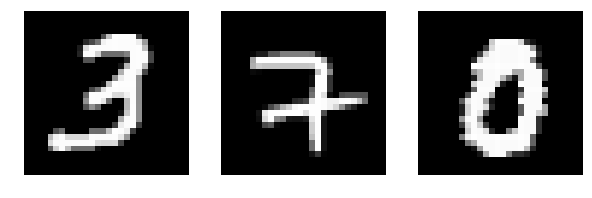

In [8]:
plt.figure(figsize=(10,10))
for i, j in enumerate(np.random.choice(range(100), 3)):
    plt.subplot(1,3,i+1)
    print(mnist['train_data'][j + 10][0].shape)
    visualize(mnist['train_data'][j + 10][0])
plt.show()

## Print 64 * 64 image

DEBUG:matplotlib.font_manager:findfont: Matching :family=NanumGothicCoding:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to NanumGothicCoding ('/usr/share/fonts/truetype/nanum/NanumGothic_Coding.ttf') with score of 0.050000


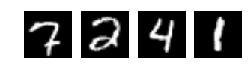

In [7]:
plt.figure(figsize=(10,10))
for i, j in enumerate(np.random.choice(range(100), 4)):
    plt.subplot(1,10,i+1)
    visualize(val[j + 10][0])
plt.show()

In [8]:
ngf = 32
nc = 1
latent_dim = 100
class Gen(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Gen, self).__init__(**kwargs)
        with self.name_scope():
            #self.dense = nn.Dense(ngf*4*1024)
            # input shape : 100 * 1 * 1
            self.convT1 = nn.Conv2DTranspose(ngf * 8, kernel_size = 4, strides = 1, padding = 0, use_bias = False)
            # (ngf * 8) * 4 * 4 image
            self.convT2 = nn.Conv2DTranspose(ngf * 4, kernel_size = 4, strides = 2, padding = 1, use_bias = False)
            # (ngf * 4) * 8 * 8 image
            self.convT3 = nn.Conv2DTranspose(ngf * 2, kernel_size = 4, strides = 2, padding = 1, use_bias = False)
            # (ngf * 2) * 16 * 16 image
            self.convT4 = nn.Conv2DTranspose(ngf, kernel_size = 4, strides = 2, padding= 1, use_bias = False)
            # (ngf) * 32 * 32 image
            # 3 * 64 * 64
            #self.convT5 = nn.Conv2DTranspose(nc, kernel_size = 3, strides = 1, padding= 1, use_bias = False)
            self.convT5 = nn.Conv2DTranspose(nc, kernel_size = 4, strides = 2, padding= 1, use_bias = False)
            
            self.bn1 = nn.BatchNorm()
            self.bn2 = nn.BatchNorm()
            self.bn3 = nn.BatchNorm()
            self.bn4 = nn.BatchNorm()            
            
    def hybrid_forward(self, F, x):
        #x = self.dense(x)
        #x = nd.reshape(x, (-1, 1024, 4, 4))
        #print('x0.shape = {}'.format(x.shape))
        x = self.convT1(x)
        x = self.bn1(x)
        x = nd.relu(x)
        #print('x1.shape = {}'.format(x.shape))
        x = self.convT2(x)
        x = self.bn2(x)
        x = nd.relu(x)
        #print('x2.shape = {}'.format(x.shape))
        x = self.convT3(x)
        x = self.bn3(x)
        x = nd.relu(x)
        #print('x3.shape = {}'.format(x.shape))
        x = self.convT4(x)
        x = self.bn4(x)
        x = nd.relu(x)
        #print('x4.shape = {}'.format(x.shape))
        x = self.convT5(x)
        x = nd.tanh(x)
        #print('x5.shape = {}'.format(x.shape))
        return x

In [9]:
gen = Gen()
z = nd.random.uniform(shape = (1, latent_dim, 1, 1), ctx = context)
gen.collect_params().initialize(mx.init.Xavier(), ctx = context)


In [10]:
gen(z).shape

(1, 1, 64, 64)

In [11]:
ndf = 32
class Disc(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Disc, self).__init__(**kwargs)
        with self.name_scope():
            self.conv1 = nn.Conv2D(ndf, kernel_size = 4, strides = 2, padding = 1, use_bias = False)
            #self.conv1 = nn.Conv2D(ndf, kernel_size = 3, strides = 1, padding = 1, use_bias = False)
            self.leaky1 = nn.LeakyReLU(.2)
            
            self.conv2 = nn.Conv2D(ndf * 2, kernel_size = 4, strides = 2, padding = 1, use_bias = False)
            self.bn2 = nn.BatchNorm()
            self.leaky2 = nn.LeakyReLU(.2)

            self.conv3 = nn.Conv2D(ndf * 4, kernel_size = 4, strides = 2, padding = 1, use_bias = False)
            self.bn3 = nn.BatchNorm()
            self.leaky3 = nn.LeakyReLU(.2)
            
            self.conv4 = nn.Conv2D(ndf * 8, kernel_size = 4, strides = 2, padding = 1, use_bias = False)
            self.bn4 = nn.BatchNorm()
            self.leaky4 = nn.LeakyReLU(.2)

            self.conv5 = nn.Conv2D(1, kernel_size = 4, strides = 1, padding = 0)
                    
    def hybrid_forward(self, F, x):
        x = self.conv1(x)
        x = self.leaky1(x)
        #print('shape = {}'.format(x.shape))
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leaky2(x)
        #print('shape = {}'.format(x.shape))
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.leaky3(x)
        #print('shape = {}'.format(x.shape))
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.leaky4(x)
        #print('shape = {}'.format(x.shape))
        x = self.conv5(x)
        #print('shape = {}'.format(x.shape))
        return x

## Start training

In [12]:
lr = .0002
beta1 = 0.5

gen = Gen()
disc = Disc()
gen.collect_params().initialize(mx.init.Normal(0.02), ctx = context)
disc.collect_params().initialize(mx.init.Normal(0.02), ctx = context)

In [13]:
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
gen_trainer = gluon.Trainer(gen.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
disc_trainer = gluon.Trainer(disc.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

In [14]:
#define loss metric
real_label = nd.ones((batch_size,), ctx=context)
fake_label = nd.zeros((batch_size,),ctx=context)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    #print('aaaaa = {}'.format(((pred > 0.5) == label)*1.))
    corr = ((pred > 0.5) == label)*1.
    #print('corr = {}'.format(corr.mean()))
    return (((pred > 0.5) == label)*1.).mean()
metric = mx.metric.CustomMetric(facc)

In [15]:
# test에서 항상 뽑아볼 수 있는 고정된 z를 사전에 뽑아둡니다.
fixed_z = nd.random.uniform(shape = (16, latent_z_size, 1, 1), ctx = context)

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown
INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 0


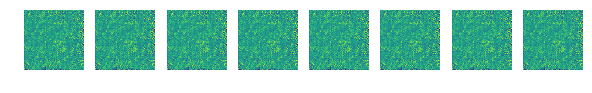

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 1


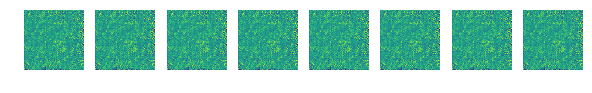

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 2


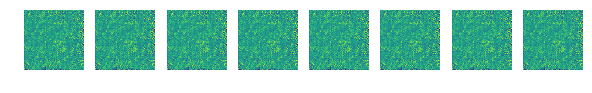

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 3


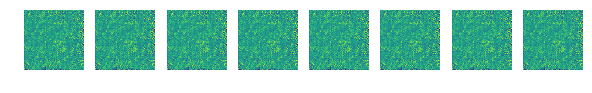

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 4


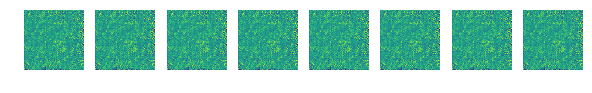

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 5


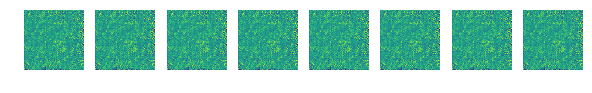

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 6


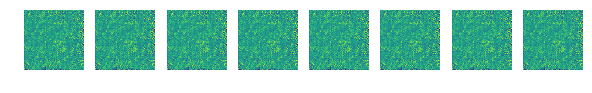

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 7


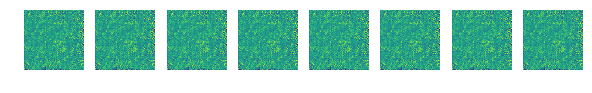

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 8


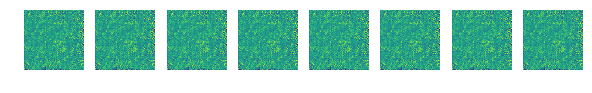

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 9


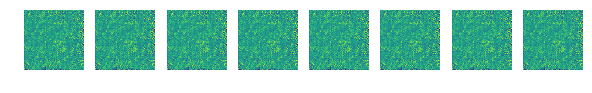

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 10


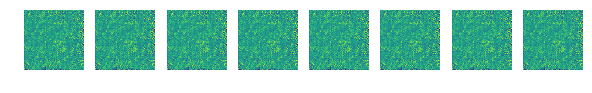

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 11


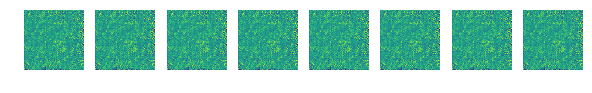

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 12


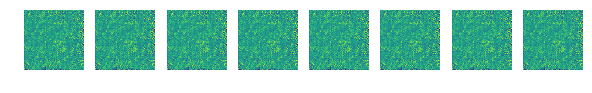

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 13


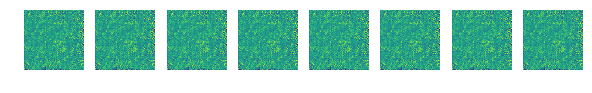

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 14


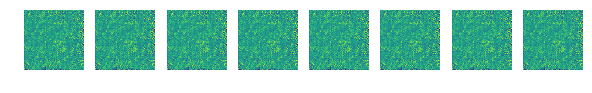

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 15


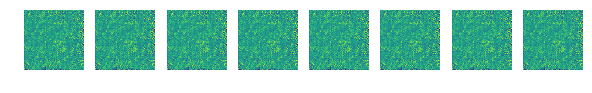

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 16


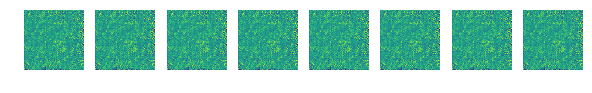

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 17


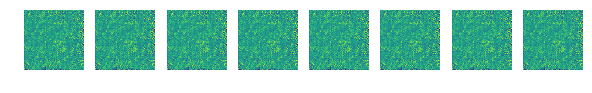

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 18


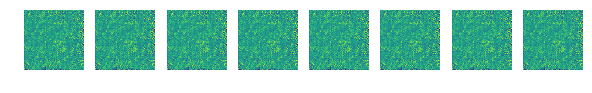

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 19


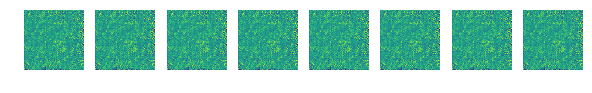

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 20


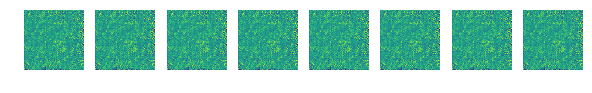

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 21


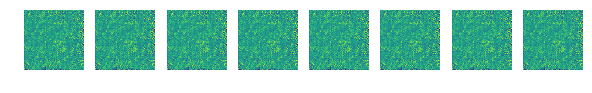

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 22


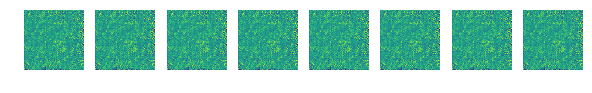

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 23


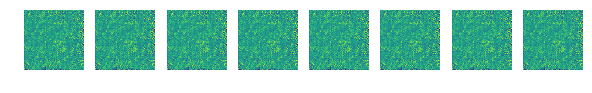

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 24


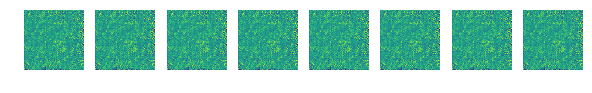

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 25


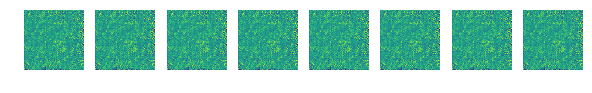

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 26


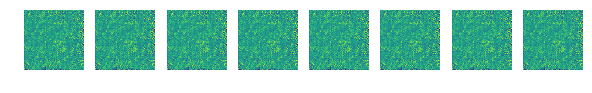

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 27


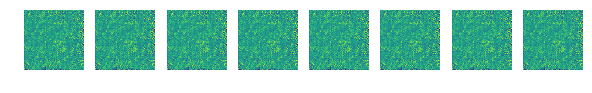

INFO:root:speed: 0.0 samples/s
INFO:root:discriminator loss = 0.002868, generator loss = 6.922328, binary training acc = nan at epoch 28


KeyboardInterrupt: 

In [17]:
%matplotlib inline

latent_z_size = 100
epochs = 50
disc_study_rate = 1
log_freq = 1

iter_loss = dict()
iter_loss['disc'] = []
iter_loss['gen'] = []


for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    #train_data.reset()
    iter = 0
    n_data = 0
    
    # For iterator
    for batch in train_data:
        data = batch.data[0].as_in_context(context)
    # For data loader
    #for data, _ in train_data:
    #    X = np.zeros((batch_size, 28, 28))
    #    for idx in range(data.shape[0]):
    #        X[idx] = data.asnumpy()[idx,0,:,:]
    #    X = np.asarray([cv2.resize(x, (32,32)) for x in X])
    #    X = X.reshape((batch_size,1,32,32))
    #    data = nd.array(X,ctx=context)
        
        ## Discriminator error
        
        latent_z = nd.random.uniform(0, 1, shape =(batch_size, latent_z_size, 1, 1), ctx = context)
        
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        with autograd.record():
            # real error
            out_real = disc(data).reshape((-1, 1))
            d_err_real = loss(out_real, real_label)
            metric.update([real_label,], [out_real,])
            # fake error
            fake = gen(latent_z)
            #print('fake shape = {}'.format(fake.shape))
            out_fake = disc(fake.detach()).reshape((-1, 1)) # Generator 고정시키기
            d_err_fake = loss(out_fake, fake_label)
            d_err = d_err_real + d_err_fake
            d_err.backward()
            metric.update([fake_label,], [out_fake,])
            #print('d_err = {}'.format(d_err))
        disc_trainer.step(data.shape[0])

        #if epoch % disc_study_rate == 0:
        ###########################
        
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake = gen(latent_z)
            out = disc(fake).reshape((-1, 1))
            g_err = loss(out, real_label)
            g_err.backward()

        gen_trainer.step(data.shape[0])
        n_data += data.shape[0]
        
            
        iter += 1
        
        if iter % 100 == 0:
            gen_img = gen(fixed_z)
            plt.figure(figsize=(10,10))
            for i in range(8):
                plt.subplot(1,8,i+1)
                # 이미 64 * 64의 크기로 되어 있음
                plt.imshow(gen_img[i][0].asnumpy())
                plt.axis('off')
                plt.Annotation(i, (0, 0))
            plt.show()
    
    #save dis/gen loss
    if epoch % log_freq == 0:
        name, acc = metric.get()
        logging.info('speed: {} samples/s'.format(n_data / (time.time() - btic)))
        logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at epoch %d'
                            %(nd.mean(d_err).asscalar(),
                            nd.mean(g_err).asscalar(), acc, epoch))
        iter_loss['disc'].append(nd.mean(d_err).asscalar())
        iter_loss['gen'].append(nd.mean(g_err).asscalar())
        gen_img = gen(fixed_z)
        #print(gen_img.shape)
        plt.figure(figsize=(10,10))
        for i in range(8):
            plt.subplot(1,8,i+1)
            # 이미 64 * 64의 크기로 되어 있음
            plt.imshow(gen_img[i][0].asnumpy())
            plt.axis('off')
            plt.Annotation(i, (0, 0))
        plt.show()

    name, acc = metric.get()
    metric.reset()

In [14]:
##load fashion-MNIST
def transform(data, label):
    return mx.nd.transpose(data.astype(np.float32), (2,0,1))/127.5 - 1, label.astype(np.float32)

train_data = gluon.data.DataLoader(
    #gluon.data.vision.FashionMNIST(train=True, transform=transform), batch_size=32, shuffle=True,last_batch='discard')
    gluon.data.vision.MNIST(train=True, transform=transform), batch_size=32, shuffle=True,last_batch='discard')

/opt/venv/lib/python3.6/site-packages/mxnet/gluon/data/vision/datasets.py:118: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  label = np.fromstring(fin.read(), dtype=np.uint8).astype(np.int32)
/opt/venv/lib/python3.6/site-packages/mxnet/gluon/data/vision/datasets.py:122: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fin.read(), dtype=np.uint8)


## Using sequential API

### Input as 64

In [151]:
# build the generator
nc = 1
ngf = 32
gen = nn.Sequential()
with gen.name_scope():
    # input is Z, going into a convolution
    gen.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    gen.add(nn.BatchNorm())
    gen.add(nn.Activation('relu'))
    # state size. (ngf*8) x 4 x 4
    gen.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    gen.add(nn.BatchNorm())
    gen.add(nn.Activation('relu'))
    # state size. (ngf*4) x 8 x 8
    gen.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
    gen.add(nn.BatchNorm())
    gen.add(nn.Activation('relu'))
    # state size. (ngf*2) x 16 x 16
    gen.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
    gen.add(nn.BatchNorm())
    gen.add(nn.Activation('relu'))
    # state size. () x 32 x 32
    gen.add(nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False))
    gen.add(nn.Activation('tanh'))
    # state size. (nc) x 64 x 64

In [152]:
# build the discriminator
ndf = 32
disc = nn.Sequential()
with disc.name_scope():
    # input is (nc) x 64 x 64
    disc.add(nn.Conv2D(ndf, 4, 2, 1, use_bias=False))
    disc.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 32 x 32
    disc.add(nn.Conv2D(ndf * 2, 4, 2, 1, use_bias=False))
    disc.add(nn.BatchNorm())
    disc.add(nn.LeakyReLU(0.2))
    # state size. (ndf*2) x 16 x 16
    disc.add(nn.Conv2D(ndf * 4, 4, 2, 1, use_bias=False))
    disc.add(nn.BatchNorm())
    disc.add(nn.LeakyReLU(0.2))
    # state size. (ndf*4) x 8 x 8
    disc.add(nn.Conv2D(ndf * 8, 4, 2, 1, use_bias=False))
    disc.add(nn.BatchNorm())
    disc.add(nn.LeakyReLU(0.2))
    # state size. (ndf*8) x 4 x 4
    disc.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))
    # state size. (ndf) x 1 x 1

### Input as 32

In [183]:
# build the generator
nc = 1
ngf = 32
gen = nn.Sequential()
with gen.name_scope():
    # input is Z, going into a convolution
    gen.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    gen.add(nn.BatchNorm())
    gen.add(nn.Activation('relu'))
    # state size. (ngf*8) x 4 x 4
    gen.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    gen.add(nn.BatchNorm())
    gen.add(nn.Activation('relu'))
    # state size. (ngf*4) x 8 x 8
    gen.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
    gen.add(nn.BatchNorm())
    gen.add(nn.Activation('relu'))
    # state size. (ngf*2) x 16 x 16
    gen.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
    gen.add(nn.BatchNorm())
    gen.add(nn.Activation('relu'))
    # state size. () x 32 x 32
    gen.add(nn.Conv2DTranspose(nc, 3, 1, 1, use_bias=False))
    gen.add(nn.Activation('tanh'))
    # state size. (nc) x 64 x 64

In [184]:
# build the discriminator
ndf = 32
disc = nn.Sequential()
with disc.name_scope():
    # input is (nc) x 64 x 64
    disc.add(nn.Conv2D(ndf, 3, 1, 1, use_bias=False))
    disc.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 32 x 32
    disc.add(nn.Conv2D(ndf * 2, 4, 2, 1, use_bias=False))
    disc.add(nn.BatchNorm())
    disc.add(nn.LeakyReLU(0.2))
    # state size. (ndf*2) x 16 x 16
    disc.add(nn.Conv2D(ndf * 4, 4, 2, 1, use_bias=False))
    disc.add(nn.BatchNorm())
    disc.add(nn.LeakyReLU(0.2))
    # state size. (ndf*4) x 8 x 8
    disc.add(nn.Conv2D(ndf * 8, 4, 2, 1, use_bias=False))
    disc.add(nn.BatchNorm())
    disc.add(nn.LeakyReLU(0.2))
    # state size. (ndf*8) x 4 x 4
    disc.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))
    # state size. (ndf) x 1 x 1

In [168]:
ctx = context

INFO:root:speed: 692.83363947511 samples/s
INFO:root:discriminator loss = 1.756033, generator loss = 2.129781, binary training acc = 0.310000 at iter 0 epoch 0


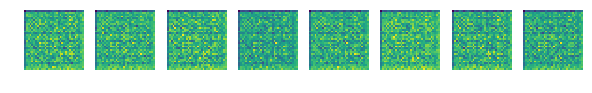

INFO:root:speed: 1854.5081532312263 samples/s
INFO:root:discriminator loss = 0.010045, generator loss = 7.126150, binary training acc = 0.983119 at iter 100 epoch 0


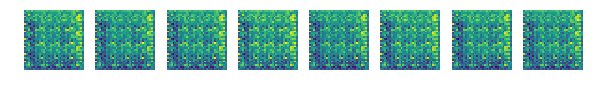

INFO:root:speed: 1864.8147324802817 samples/s
INFO:root:discriminator loss = 0.002811, generator loss = 7.437020, binary training acc = 0.991468 at iter 200 epoch 0


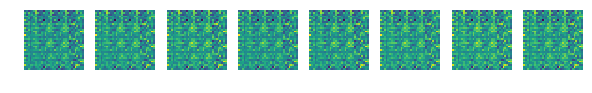

INFO:root:speed: 1933.4916032434576 samples/s
INFO:root:discriminator loss = 0.001745, generator loss = 7.576642, binary training acc = 0.994302 at iter 300 epoch 0


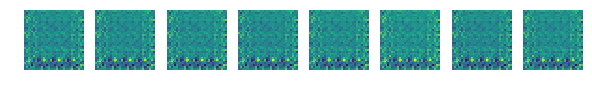

INFO:root:speed: 1977.167585098309 samples/s
INFO:root:discriminator loss = 0.002095, generator loss = 7.795444, binary training acc = 0.995723 at iter 400 epoch 0


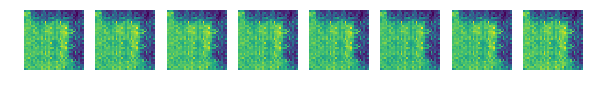

INFO:root:speed: 2010.393469810335 samples/s
INFO:root:discriminator loss = 0.001311, generator loss = 7.954771, binary training acc = 0.996577 at iter 500 epoch 0


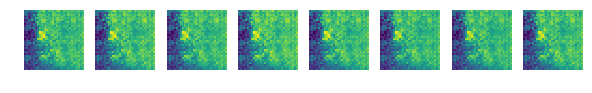

INFO:root:speed: 1859.169063966915 samples/s
INFO:root:discriminator loss = 0.000823, generator loss = 7.837004, binary training acc = 0.997146 at iter 600 epoch 0


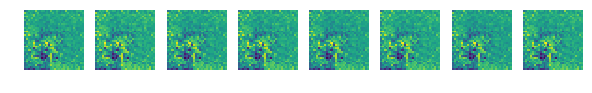

INFO:root:speed: 1863.1497119301348 samples/s
INFO:root:discriminator loss = 0.000306, generator loss = 8.624855, binary training acc = 0.997553 at iter 700 epoch 0


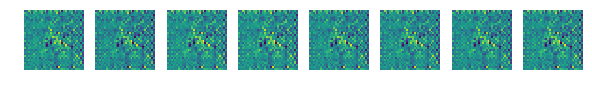

INFO:root:speed: 1770.1144962460594 samples/s
INFO:root:discriminator loss = 0.000238, generator loss = 9.058607, binary training acc = 0.997859 at iter 800 epoch 0


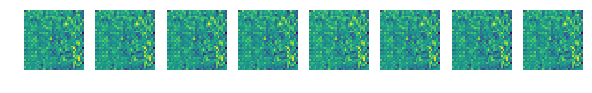

INFO:root:speed: 1865.702301043988 samples/s
INFO:root:discriminator loss = 0.000148, generator loss = 9.505525, binary training acc = 0.998097 at iter 900 epoch 0


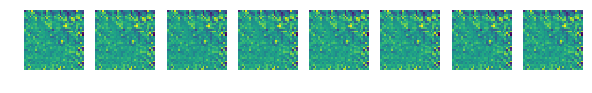

INFO:root:speed: 1770.7870860969092 samples/s
INFO:root:discriminator loss = 0.000331, generator loss = 9.310319, binary training acc = 0.998287 at iter 1000 epoch 0


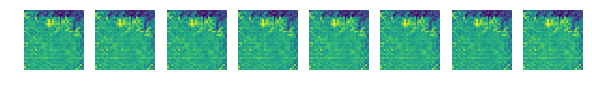

INFO:root:speed: 1876.6628784150193 samples/s
INFO:root:discriminator loss = 0.000205, generator loss = 9.329511, binary training acc = 0.998442 at iter 1100 epoch 0


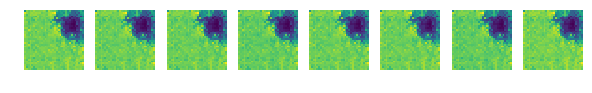

INFO:root:speed: 1861.6363813903117 samples/s
INFO:root:discriminator loss = 0.000069, generator loss = 10.575661, binary training acc = 0.998572 at iter 1200 epoch 0


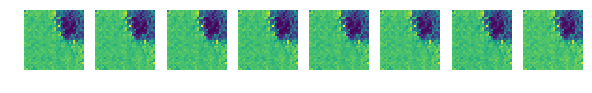

INFO:root:speed: 1882.60133846216 samples/s
INFO:root:discriminator loss = 0.000048, generator loss = 10.738156, binary training acc = 0.998682 at iter 1300 epoch 0


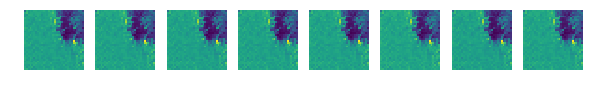

INFO:root:speed: 1841.6586899440606 samples/s
INFO:root:discriminator loss = 0.000041, generator loss = 11.076286, binary training acc = 0.998776 at iter 1400 epoch 0


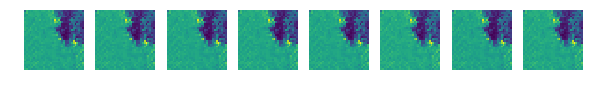

INFO:root:speed: 1920.143565421609 samples/s
INFO:root:discriminator loss = 0.000037, generator loss = 11.370396, binary training acc = 0.998857 at iter 1500 epoch 0


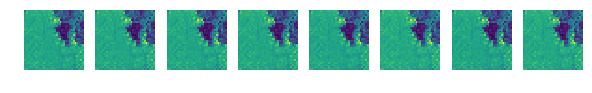

INFO:root:speed: 1862.611908483729 samples/s
INFO:root:discriminator loss = 0.000035, generator loss = 11.307627, binary training acc = 0.998929 at iter 1600 epoch 0


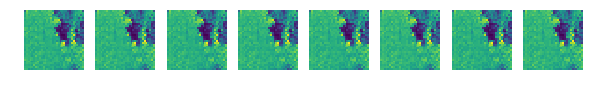

INFO:root:speed: 1994.049662215165 samples/s
INFO:root:discriminator loss = 0.000096, generator loss = 9.821514, binary training acc = 0.998992 at iter 1700 epoch 0


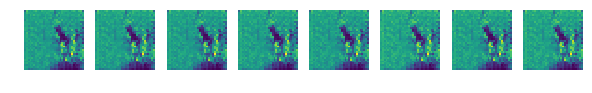

INFO:root:speed: 1848.289112453675 samples/s
INFO:root:discriminator loss = 0.106500, generator loss = 7.541528, binary training acc = 0.998234 at iter 1800 epoch 0


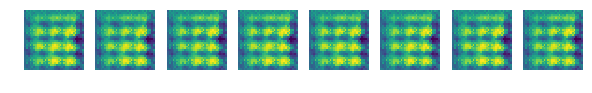

INFO:root:speed: 1062.2175286111892 samples/s
INFO:root:discriminator loss = 0.058604, generator loss = 5.500369, binary training acc = 1.000000 at iter 0 epoch 1


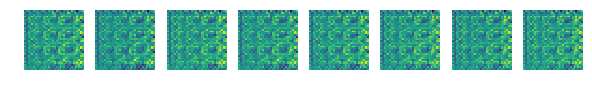

INFO:root:speed: 1992.0513697328927 samples/s
INFO:root:discriminator loss = 0.024006, generator loss = 4.785697, binary training acc = 0.972525 at iter 100 epoch 1


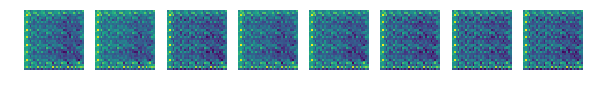

INFO:root:speed: 1590.4745292248422 samples/s
INFO:root:discriminator loss = 0.287158, generator loss = 2.453506, binary training acc = 0.977811 at iter 200 epoch 1


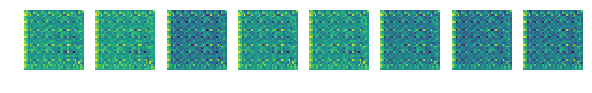

INFO:root:speed: 1816.2113476835673 samples/s
INFO:root:discriminator loss = 0.383927, generator loss = 2.367821, binary training acc = 0.974419 at iter 300 epoch 1


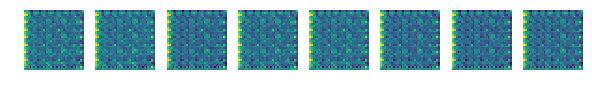

INFO:root:speed: 1863.7292323005213 samples/s
INFO:root:discriminator loss = 0.307783, generator loss = 2.397307, binary training acc = 0.969676 at iter 400 epoch 1


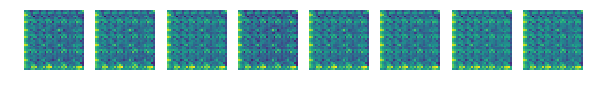

INFO:root:speed: 1859.4905170197108 samples/s
INFO:root:discriminator loss = 0.260233, generator loss = 5.300933, binary training acc = 0.974930 at iter 500 epoch 1


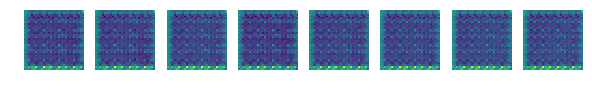

INFO:root:speed: 1846.74289689546 samples/s
INFO:root:discriminator loss = 0.249607, generator loss = 3.058355, binary training acc = 0.970774 at iter 600 epoch 1


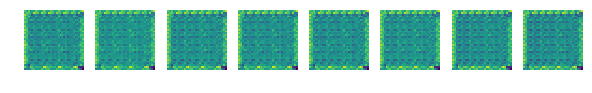

INFO:root:speed: 1860.7114021311897 samples/s
INFO:root:discriminator loss = 0.032575, generator loss = 4.443895, binary training acc = 0.971427 at iter 700 epoch 1


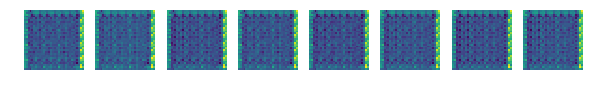

INFO:root:speed: 1861.3307061804658 samples/s
INFO:root:discriminator loss = 0.138798, generator loss = 2.968724, binary training acc = 0.969894 at iter 800 epoch 1


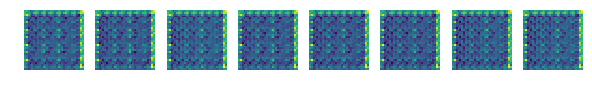

INFO:root:speed: 1877.5785736987946 samples/s
INFO:root:discriminator loss = 0.036190, generator loss = 5.028327, binary training acc = 0.973213 at iter 900 epoch 1


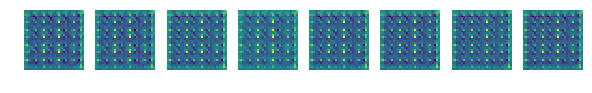

INFO:root:speed: 2029.2630061299235 samples/s
INFO:root:discriminator loss = 0.698242, generator loss = 2.577410, binary training acc = 0.971548 at iter 1000 epoch 1


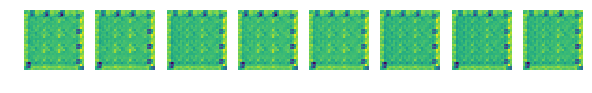

INFO:root:speed: 1856.5028217328759 samples/s
INFO:root:discriminator loss = 0.030288, generator loss = 4.354252, binary training acc = 0.972893 at iter 1100 epoch 1


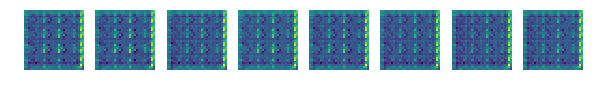

INFO:root:speed: 1867.9041265486806 samples/s
INFO:root:discriminator loss = 0.024275, generator loss = 5.598819, binary training acc = 0.974992 at iter 1200 epoch 1


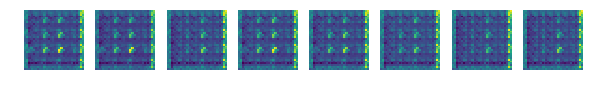

INFO:root:speed: 1878.2343906032395 samples/s
INFO:root:discriminator loss = 0.011449, generator loss = 5.915283, binary training acc = 0.976914 at iter 1300 epoch 1


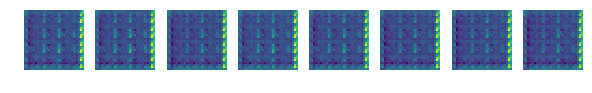

INFO:root:speed: 1891.225871032614 samples/s
INFO:root:discriminator loss = 1.505240, generator loss = 0.836705, binary training acc = 0.976392 at iter 1400 epoch 1


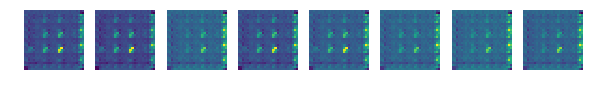

INFO:root:speed: 1860.3152637695043 samples/s
INFO:root:discriminator loss = 0.035528, generator loss = 4.279048, binary training acc = 0.971352 at iter 1500 epoch 1


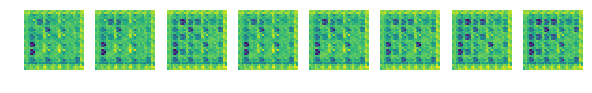

INFO:root:speed: 1870.8618990057585 samples/s
INFO:root:discriminator loss = 0.090781, generator loss = 4.119358, binary training acc = 0.972245 at iter 1600 epoch 1


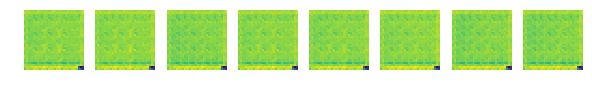

INFO:root:speed: 1870.586556300842 samples/s
INFO:root:discriminator loss = 0.093721, generator loss = 4.198723, binary training acc = 0.968586 at iter 1700 epoch 1


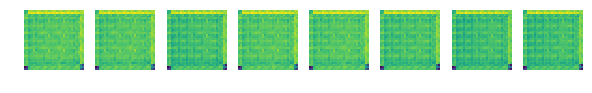

INFO:root:speed: 1870.478110213747 samples/s
INFO:root:discriminator loss = 0.075755, generator loss = 3.256311, binary training acc = 0.969106 at iter 1800 epoch 1


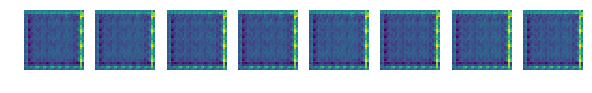

INFO:root:speed: 1034.243964265195 samples/s
INFO:root:discriminator loss = 0.027309, generator loss = 4.234416, binary training acc = 1.000000 at iter 0 epoch 2


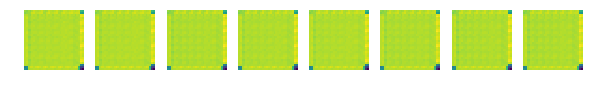

INFO:root:speed: 1817.3130499963172 samples/s
INFO:root:discriminator loss = 0.436611, generator loss = 2.432088, binary training acc = 0.968416 at iter 100 epoch 2


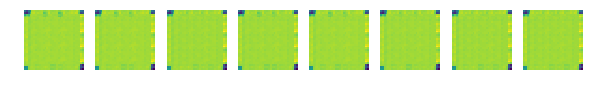

INFO:root:speed: 1861.6859598039912 samples/s
INFO:root:discriminator loss = 0.513041, generator loss = 1.717196, binary training acc = 0.952239 at iter 200 epoch 2


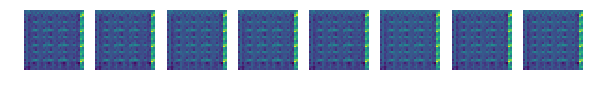

INFO:root:speed: 1844.9476554939738 samples/s
INFO:root:discriminator loss = 0.056548, generator loss = 3.996499, binary training acc = 0.959817 at iter 300 epoch 2


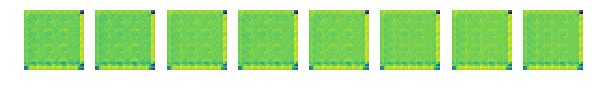

INFO:root:speed: 1937.8061964647072 samples/s
INFO:root:discriminator loss = 0.014123, generator loss = 5.484974, binary training acc = 0.965037 at iter 400 epoch 2


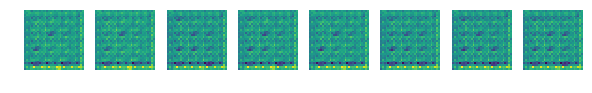

INFO:root:speed: 2007.237783488627 samples/s
INFO:root:discriminator loss = 0.010488, generator loss = 6.019732, binary training acc = 0.971986 at iter 500 epoch 2


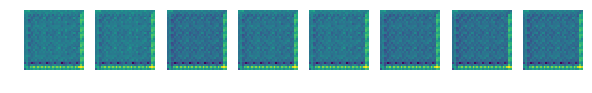

INFO:root:speed: 1853.9261577358457 samples/s
INFO:root:discriminator loss = 1.054413, generator loss = 1.834721, binary training acc = 0.947238 at iter 600 epoch 2


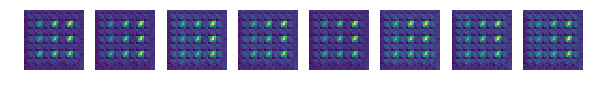

INFO:root:speed: 1710.2924086299488 samples/s
INFO:root:discriminator loss = 0.522567, generator loss = 1.325065, binary training acc = 0.939165 at iter 700 epoch 2


KeyboardInterrupt: 

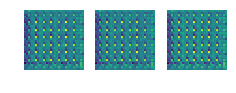

In [188]:
from datetime import datetime
import time
import logging

real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    iter = 0
    for (data, label) in train_data:
        # 원래 데이터 형태는 1 X 28 X 28임 -> DCGAN 네트워크 활용을 위해서 이미지 데이터의 크기를 조절
        X = np.zeros((batch_size, 28, 28))
        for idx in range(data.shape[0]):
            X[idx] = data.asnumpy()[idx,0,:,:]
        X = np.asarray([cv2.resize(x, (32,32)) for x in X])
        X = X.reshape((batch_size,1,32,32))
        data = nd.array(X,ctx=ctx)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)
    
        #Gradient를 산출 및 이를 Back prop.에 적용
        with autograd.record():
            # train with real image
            output = disc(data).reshape((-1, 1))
            errD_real = loss(output, real_label)
            metric.update([real_label,], [output,])

            # train with fake image
            fake = gen(latent_z)
            output = disc(fake.detach()).reshape((-1, 1))
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        disc_trainer.step(data.shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake = gen(latent_z)
            output = disc(fake).reshape((-1, 1))
            errG = loss(output, real_label)
            errG.backward()

        gen_trainer.step(data.shape[0])

        # Print log infomation every ten batches
        if iter % 100 == 0:
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                     %(nd.mean(errD).asscalar(),
                       nd.mean(errG).asscalar(), acc, iter, epoch))
            gen_img = gen(fixed_z)
            #print(gen_img.shape)
            plt.figure(figsize=(10,10))
            for i in range(8):
                plt.subplot(1,8,i+1)
                # 이미 64 * 64의 크기로 되어 있음
                plt.imshow(gen_img[i][0].asnumpy())
                plt.axis('off')
                plt.Annotation(i, (0, 0))
            plt.show()
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    # logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    # logging.info('time: %f' % (time.time() - tic))

    # Visualize one generated image for each epoch
